<div align="center">

## Regression Project for CSGO Player Score Prediction
### Autor : Vinh Tang

</div>

### Libraries import & Settings

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import f_classif, chi2
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from ydata_profiling import ProfileReport

from missforest import MissForest

import pickle

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
from lazypredict.Supervised import LazyRegressor




In [2]:
pd.options.display.float_format = '{:.5f}'.format

### Step 1 : Data collection : skip because data is already available
### Step between step 1 and step 2: Importing data

In [3]:
df = pd.read_csv("csgo.csv", delimiter=",")
df

,map,day,month,year,date,wait_time_s,match_time_s,team_a_rounds,team_b_rounds,ping,kills,assists,deaths,mvps,hs_percent,points,result
0,Mirage,3.00000,8.00000,2018.00000,3/8/2018,327.00000,2906.00000,16.00000,13.00000,215.00000,17.00000,2.00000,21.00000,2.00000,5.00000,45.00000,Win
1,Mirage,2.00000,8.00000,2018.00000,2/8/2018,336.00000,2592.00000,16.00000,11.00000,199.00000,13.00000,4.00000,24.00000,2.00000,0.00000,40.00000,Lost
2,Mirage,31.00000,7.00000,2018.00000,31/7/2018,414.00000,2731.00000,16.00000,14.00000,85.00000,15.00000,3.00000,18.00000,3.00000,26.00000,37.00000,Win
3,Mirage,31.00000,7.00000,2018.00000,31/7/2018,317.00000,2379.00000,11.00000,16.00000,93.00000,12.00000,2.00000,15.00000,2.00000,16.00000,30.00000,Lost
4,Mirage,30.00000,7.00000,2018.00000,30/7/2018,340.00000,3467.00000,15.00000,15.00000,94.00000,33.00000,5.00000,20.00000,5.00000,30.00000,83.00000,Tie
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128,Dust II,23.00000,7.00000,2015.00000,23/7/2015,2.00000,1573.00000,16.00000,4.00000,46.00000,12.00000,2.00000,20.00000,0.00000,16.00000,26.00000,Lost
1129,Dust II,23.00000,7.00000,2015.00000,23/7/2015,29.00000,2126.00000,16.00000,8.00000,41.00000,19.00000,6.00000,21.00000,2.00000,31.00000,51.00000,Lost
1130,Dust II,23.00000,7.00000,2015.00000,23/7/2015,10.00000,2555.00000,11.00000,16.00000,17.00000,9.00000,3.00000,20.00000,2.00000,55.00000,30.00000,Lost
1131,Dust II,23.00000,7.00000,2015.00000,23/7/2015,9.00000,2293.00000,8.00000,16.00000,20.00000,11.00000,4.00000,20.00000,1.00000,27.00000,31.00000,Lost


Identify features and target for verifying by F-Statistics and P-value

In [4]:
# Identify target
target = "points"
x = df.drop(target, axis=1) # Split the X columns (feature columns)
y = df[target]

In [5]:
# Verfifie ANOVA

x_num = x.select_dtypes(include='number') 
f_values, p_values = f_classif(x_num, y)

for name, f, p in zip(x_num.columns, f_values, p_values):
    print(f"{name}: F = {f:.2f}, p = {p:.4f}")


day: F = 1.05, p = 0.3524
month: F = 1.15, p = 0.1753
year: F = 0.95, p = 0.6167
wait_time_s: F = 0.96, p = 0.5858
match_time_s: F = 5.62, p = 0.0000
team_a_rounds: F = 1.95, p = 0.0000
team_b_rounds: F = 1.61, p = 0.0007
ping: F = 1.45, p = 0.0071
kills: F = 139.20, p = 0.0000
assists: F = 4.09, p = 0.0000
deaths: F = 3.72, p = 0.0000
mvps: F = 11.79, p = 0.0000
hs_percent: F = 1.38, p = 0.0169


**Explanation of ANOVA F-test (`f_classif`) Results for Numerical Features**

After applying the ANOVA F-test to evaluate the relationship between numerical features and the numerical target (e.g., player points), I obtained the following results:

| Feature         | F-value | p-value | Explanation |
|-----------------|---------|---------|-------------|
| `day`           | 1.05    | 0.3524  | Not statistically significant (p > 0.05) → Unrelated to the target |
| `month`         | 1.15    | 0.1753  | Not significant → Likely unrelated to the target |
| `year`          | 0.95    | 0.6167  | Not significant → Likely unrelated to the target |
| `wait_time_s`   | 0.96    | 0.5858  | Not statistically meaningful (p > 0.05) |
| `match_time_s`  | 5.62   | 0.0000  | Important → Impacts the target outcome |
| `team_a_rounds` | 1.95   | 0.0000  | Important → Shows a relationship with the target |
| `team_b_rounds` | 1.61   | 0.0007  | Similarly important as `team_a_rounds` |
| `ping`          | 1.45    | 0.0071  | Important → Impacts the target outcome |
| `kills`         | 139.20   | 0.0000  | Very important → Strongly impacts the target outcome |
| `assists`       | 4.09   | 0.0000  | Statistically relevant to the target |
| `deaths`        | 3.72  | 0.0000  | Extremely important → Strong distinguishing power |
| `mvps`          | 11.79   | 0.0000  | Very important |
| `hs_percent`    | 0.10    | 0.0169   | Important |



**Conclusion:**

**Features to **keep** (p-value < 0.05):**
- `match_time_s`
- `ping` 
- `kills`
- `assists`
- `deaths`
- `mvps`
- `hs_percent` (thanks to domain knowledge although should remove according to p_value result)

**Features to **consider removing** (p-value > 0.05):**
- `day`
- `month`
- `year`
- `date` (related to the three features above)
- `wait_time_s`
- `team_a_rounds` (thanks to domain knowledge although should keep according to p_value result)
- `team_b_rounds` (thanks to domain knowledge although should keep according to p_value result too)

**Feature to consider after:**
- `map` and `results` (Check the correlation with the target column after encoding both columns)

In [6]:
# Logically, the date, month, year values ​​and the team a, 
# team b columns do not affect the win, lose or draw results, so I delete them.

df.drop(columns=["day", "month", "year", "date", "team_a_rounds", "team_b_rounds", "wait_time_s"], axis=1, inplace=True)
df

,map,match_time_s,ping,kills,assists,deaths,mvps,hs_percent,points,result
0,Mirage,2906.00000,215.00000,17.00000,2.00000,21.00000,2.00000,5.00000,45.00000,Win
1,Mirage,2592.00000,199.00000,13.00000,4.00000,24.00000,2.00000,0.00000,40.00000,Lost
2,Mirage,2731.00000,85.00000,15.00000,3.00000,18.00000,3.00000,26.00000,37.00000,Win
3,Mirage,2379.00000,93.00000,12.00000,2.00000,15.00000,2.00000,16.00000,30.00000,Lost
4,Mirage,3467.00000,94.00000,33.00000,5.00000,20.00000,5.00000,30.00000,83.00000,Tie
...,...,...,...,...,...,...,...,...,...,...
1128,Dust II,1573.00000,46.00000,12.00000,2.00000,20.00000,0.00000,16.00000,26.00000,Lost
1129,Dust II,2126.00000,41.00000,19.00000,6.00000,21.00000,2.00000,31.00000,51.00000,Lost
1130,Dust II,2555.00000,17.00000,9.00000,3.00000,20.00000,2.00000,55.00000,30.00000,Lost
1131,Dust II,2293.00000,20.00000,11.00000,4.00000,20.00000,1.00000,27.00000,31.00000,Lost


In [7]:
df.info(); df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1133 entries, 0 to 1132
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   map           1133 non-null   object 
 1   match_time_s  1133 non-null   float64
 2   ping          1133 non-null   float64
 3   kills         1133 non-null   float64
 4   assists       1133 non-null   float64
 5   deaths        1133 non-null   float64
 6   mvps          1133 non-null   float64
 7   hs_percent    1133 non-null   float64
 8   points        1133 non-null   float64
 9   result        1133 non-null   object 
dtypes: float64(8), object(2)
memory usage: 88.6+ KB


,match_time_s,ping,kills,assists,deaths,mvps,hs_percent,points
count,1133.00000,1133.00000,1133.00000,1133.00000,1133.00000,1133.00000,1133.00000,1133.00000
mean,2291.43866,72.49426,14.70609,4.15887,17.03442,1.82524,24.90203,39.21712
std,474.52433,65.99597,5.94877,2.36348,4.79248,1.48770,13.67221,14.89802
min,630.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,1942.00000,31.00000,11.00000,2.00000,14.00000,1.00000,16.00000,29.00000
50%,2311.00000,76.00000,14.00000,4.00000,18.00000,2.00000,23.00000,39.00000
75%,2648.00000,92.00000,18.00000,6.00000,21.00000,3.00000,33.00000,49.00000
max,3603.00000,724.00000,36.00000,14.00000,27.00000,8.00000,100.00000,89.00000


In [8]:
print("\na) Filter and view the first two rows of the DataFrame :")
print(df.iloc[[0,2,4]]) # or df.iloc[:3:2]
print("\n")
print(f"\nb) Filter to get the first cell value of the ping column : {df.loc[2, 'mvps']}")
print("\n")
print(f"\nc) Filter on demand (eg people with 10+ kills and 12 or + headshots) : \n {df[(df['kills'] > 10) & (df['assists'] >= 12)]}")
print("\n")
print("\nd) Aggregate and view maps by the average value of two columns waiting time, matching time :")
df.groupby('map')[['match_time_s', 'ping']].mean()


a) Filter and view the first two rows of the DataFrame :
      map  match_time_s      ping    kills  assists   deaths    mvps  \
0  Mirage    2906.00000 215.00000 17.00000  2.00000 21.00000 2.00000   
2  Mirage    2731.00000  85.00000 15.00000  3.00000 18.00000 3.00000   
4  Mirage    3467.00000  94.00000 33.00000  5.00000 20.00000 5.00000   

   hs_percent   points result  
0     5.00000 45.00000    Win  
2    26.00000 37.00000    Win  
4    30.00000 83.00000    Tie  



b) Filter to get the first cell value of the ping column : 3.0



c) Filter on demand (eg people with 10+ kills and 12 or + headshots) : 
           map  match_time_s      ping    kills  assists   deaths    mvps  \
125    Mirage    2481.00000  87.00000 18.00000 13.00000 19.00000 4.00000   
135    Mirage    2429.00000  88.00000 11.00000 12.00000 18.00000 1.00000   
178    Mirage    3174.00000  80.00000 17.00000 12.00000 26.00000 1.00000   
364    Mirage    2793.00000  32.00000 23.00000 13.00000 24.00000 1.00000   
580

,match_time_s,ping
map,,
Austria,2513.00000,70.00000
Cache,2357.44068,76.89831
Canals,2189.00000,126.00000
Cobblestone,2528.08333,51.08333
Dust II,2265.24863,82.25411
Inferno,2320.99242,43.12121
Italy,1899.00000,34.00000
Mirage,2303.54821,69.81818
Nuke,2500.75000,30.25000


Visualization

Box Plot


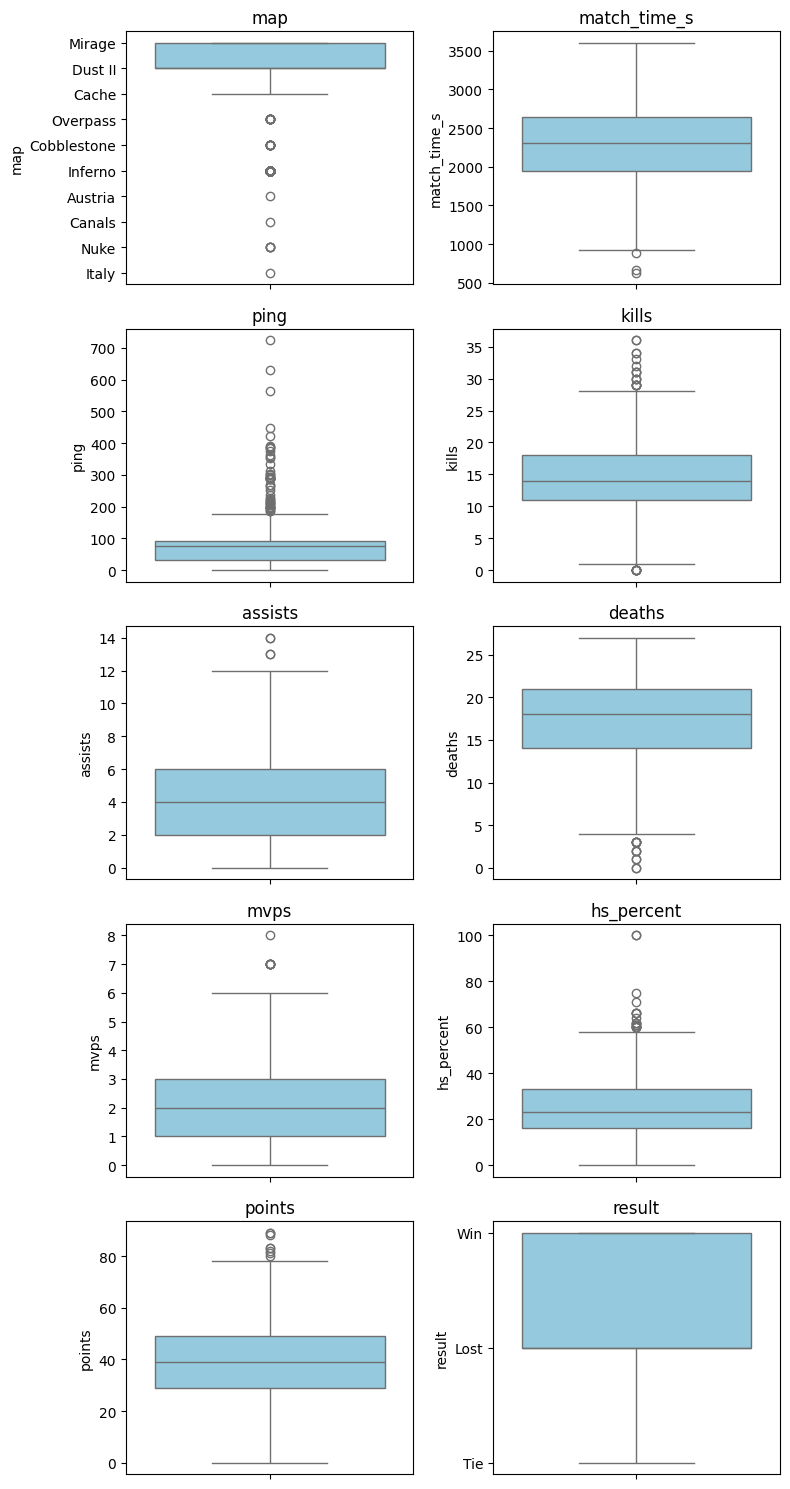

In [9]:
fig, axs = plt.subplots(5, 2, figsize=(8, 15))
columns = df.columns
for i, ax in enumerate(axs.flat):
    if i < len(columns):
        sns.boxplot(y=df[columns[i]], ax=ax, color='skyblue')
        ax.set_title(columns[i])
    else:
        ax.axis('off')  # tắt ô trống nếu có

plt.tight_layout()
plt.show()


Strip Plot


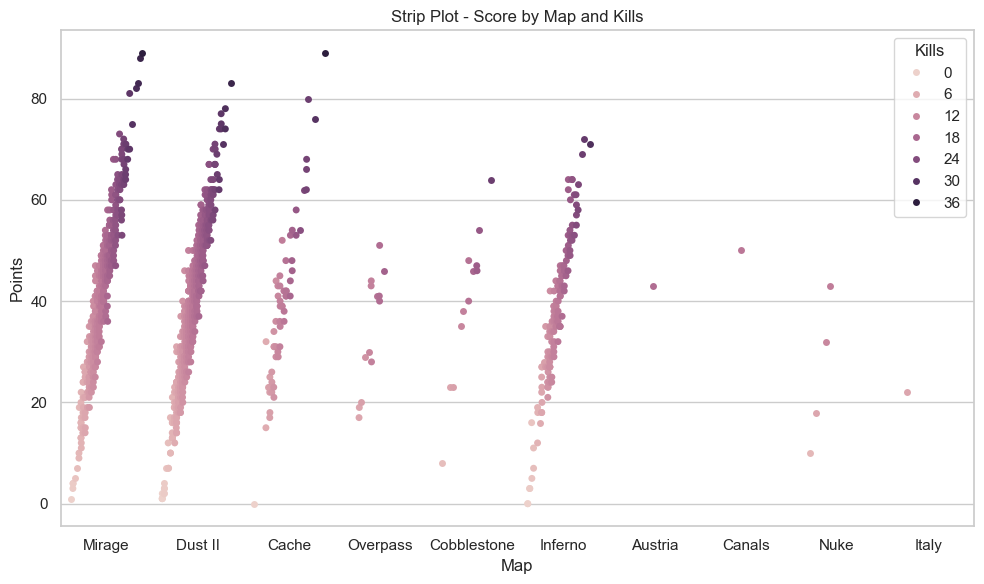

In [10]:
sns.set(style='whitegrid')

# Tạo strip plot
plt.figure(figsize=(10, 6))
sns.stripplot(data=df, x='map', y='points', hue='kills', jitter=True, dodge=True)

# Tùy chỉnh hiển thị
plt.title('Strip Plot - Score by Map and Kills')
plt.ylabel('Points')
plt.xlabel('Map')
plt.legend(title='Kills')
plt.tight_layout()

Correlations between numerical features

In [11]:
correlations = df.corr(numeric_only=True)
corr_df = pd.DataFrame(correlations)
corr_df

,match_time_s,ping,kills,assists,deaths,mvps,hs_percent,points
match_time_s,1.00000,0.05850,0.43918,0.31073,0.61981,0.22105,0.00220,0.49157
ping,0.05850,1.00000,0.09983,0.08518,0.12669,0.03757,-0.04768,0.09447
kills,0.43918,0.09983,1.00000,0.27469,0.26432,0.63802,-0.02465,0.95437
assists,0.31073,0.08518,0.27469,1.00000,0.31000,0.18503,0.08058,0.42078
deaths,0.61981,0.12669,0.26432,0.31000,1.00000,-0.00324,0.07435,0.30173
mvps,0.22105,0.03757,0.63802,0.18503,-0.00324,1.00000,-0.05061,0.66135
hs_percent,0.00220,-0.04768,-0.02465,0.08058,0.07435,-0.05061,1.00000,-0.01351
points,0.49157,0.09447,0.95437,0.42078,0.30173,0.66135,-0.01351,1.00000


*Comment :*

| Biến           | Corr với `points`               |
| -------------- | ------------------------------- |
| `kills`        | **0.95** ✅ Very high             |
| `mvps`         | **0.66** ✅ High                  |
| `assists`      | 0.42 ✅ Medium              |
| `match_time_s` | 0.49 ✅ Medium               |
| `deaths`       | 0.30                            |
| `ping`         | 0.09 ❌ Very low                 |
| `hs_percent`   | -0.01 ❌ Almost irrelevant |



Check for multicollinearity

In [12]:
X_for_verifying = df[[ "match_time_s", "ping", "kills", "assists", "deaths", "mvps", "hs_percent"]]
X_for_verifying = add_constant(X_for_verifying)

vif = pd.DataFrame()
vif["features"] = X_for_verifying.columns
vif["VIF"] = [variance_inflation_factor(X_for_verifying.values, i) for i in range(X_for_verifying.shape[1])]
vif

,features,VIF
0,const,28.80072
1,match_time_s,1.90406
2,ping,1.02986
3,kills,2.06201
4,assists,1.18276
5,deaths,1.79258
6,mvps,1.80000
7,hs_percent,1.02008


*Note:* here there is no multicollinearity between features and in addition there are very strong correlations so I will use linear models to train the model.

ydata-profiling

In [13]:
# profile = ProfileReport(df, title="Regression - CSGO Report")
# profile.to_file("Regression_CSGO_Report.html")

# After using it, comment it out so it runs only once, 
# that's enough because it only shows us the unprocessed data at first.

### Step before data preprocessing step (step 3): data division step

Identify features and target

In [14]:
# Xác định target
target = "points"

x = df.drop(target, axis=1)
y = df[target]

Identify train set, validation test and test set

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=42, shuffle=True)

x_test

,map,match_time_s,ping,kills,assists,deaths,mvps,hs_percent,result
783,Inferno,2210.00000,33.00000,16.00000,1.00000,15.00000,2.00000,18.00000,Lost
898,Inferno,1554.00000,39.00000,15.00000,2.00000,10.00000,4.00000,33.00000,Win
413,Dust II,2296.00000,64.00000,16.00000,4.00000,11.00000,3.00000,25.00000,Win
467,Dust II,2603.00000,82.00000,20.00000,5.00000,22.00000,2.00000,10.00000,Lost
745,Inferno,3060.00000,16.00000,14.00000,6.00000,25.00000,0.00000,21.00000,Tie
...,...,...,...,...,...,...,...,...,...
66,Mirage,1914.00000,106.00000,11.00000,6.00000,17.00000,1.00000,27.00000,Lost
896,Mirage,2650.00000,41.00000,11.00000,4.00000,18.00000,2.00000,18.00000,Lost
67,Mirage,1999.00000,287.00000,10.00000,6.00000,23.00000,0.00000,30.00000,Lost
549,Dust II,2185.00000,91.00000,24.00000,6.00000,15.00000,3.00000,20.00000,Win


### Step 3 : Data pre-processing






#### 3.1) Preprocessing NUMERICAL FEATURE


It includes columns like `match_time_s, ping, kills, assists, deaths, mvps, hs_percent`

I write `SafeMissForest` transformer and call it to use in Pipeline as usual

In [16]:
class SafeMissForest(BaseEstimator, TransformerMixin):
    def __init__(self, **kwargs):
        self.mf = MissForest(**kwargs)
        self.imputation_performed = False

    def fit(self, X, y=None):
        # Only fit if there is NaN
        if pd.DataFrame(X).isnull().values.any():
            self.mf.fit(X)
            self.imputation_performed = True
        return self

    def transform(self, X):
        if pd.DataFrame(X).isnull().values.any():
            return self.mf.transform(X)
        else:
            return X  # Return integer if there is no missing

In [17]:
num_transformer = Pipeline(steps=[
        ('safe_imputer', SafeMissForest()),  # no error if there is no missing   
        ('scaler', StandardScaler())
    ])

processed_num_data = num_transformer.fit_transform(x_train[[
    "match_time_s", "ping", "kills", "assists", "deaths", "mvps", "hs_percent"
]])

for idx, (i,j) in enumerate(zip(x_train[["match_time_s", "ping", "assists", "deaths", "mvps", "hs_percent"]].values, processed_num_data)) :
    if idx >= 5 :
        break
    print(f'{idx}, not processed data is {i}, processed data is {j}')

0, not processed data is [2.336e+03 1.960e+02 2.000e+00 1.800e+01 0.000e+00 0.000e+00], processed data is [ 0.12735072  1.81847831 -1.09893687 -0.88482119  0.20957906 -1.21994547
 -1.78983468]
1, not processed data is [2557.   92.    6.   16.    6.   16.], processed data is [ 0.59107714  0.29795882  1.74765339  0.7852788  -0.2086558   2.85103279
 -0.63875023]
2, not processed data is [1.515e+03 0.000e+00 1.000e+00 6.000e+00 0.000e+00 0.000e+00], processed data is [-1.59536147 -1.04711611 -2.27106227 -1.30234619 -2.29983009 -1.21994547
 -1.78983468]
3, not processed data is [2.492e+03 8.800e+01 9.000e+00 2.000e+01 1.000e+00 2.200e+01], processed data is [ 0.45468702  0.2394773   1.24531393  2.0378538   0.62781391 -0.5414491
 -0.20709356]
4, not processed data is [2976.   25.    3.   24.    0.   14.], processed data is [ 1.47026887 -0.68160662 -0.09425796 -0.46729619  1.46428363 -1.21994547
 -0.78263578]


#### 3.2) : Preprocessing CATEGORICAL ORDINAL

It includes `map` and `result`


In [18]:
nominal_transformer = Pipeline(steps=[("imputer", SafeMissForest(categorical=[0, 8])),
                                      ("nom_encoder", OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop=None))])

processed_nominal_data = nominal_transformer.fit_transform(x_train[["map", "result"]])

for idx, (i,j) in enumerate(zip(x_train[["map", "result"]].values, processed_nominal_data)):
    if idx < 10:
        print(f'{idx}, not processed data is {i}, processed data is {j}')

0, not processed data is ['Cache' 'Lost'], processed data is [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
1, not processed data is ['Dust II' 'Win'], processed data is [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
2, not processed data is ['Inferno' 'Lost'], processed data is [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
3, not processed data is ['Dust II' 'Lost'], processed data is [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
4, not processed data is ['Dust II' 'Lost'], processed data is [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
5, not processed data is ['Dust II' 'Win'], processed data is [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
6, not processed data is ['Inferno' 'Win'], processed data is [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
7, not processed data is ['Dust II' 'Lost'], processed data is [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
8, not processed data is ['Inferno' 'Win'], processed data is [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
9, not processed data is ['Mirage' 'Tie'], processed data is [0. 0. 0.

Check the relevance between feature "map" and target column

In [19]:
# đánh giá sự liên hệ giữa các đặc trưng one-hot từ "map" và "result" (sau khi encode) và biến mục tiêu y_train (giả sử là nhãn phân loại)
chi_scores, p_values = chi2(processed_nominal_data, y_train) 
print("Chi-squared scores:", chi_scores)
print("p-values:", p_values)

Chi-squared scores: [ 35.24        85.05526946  59.4        148.65907049  47.00410934
  66.39631233  74.5         64.07480637  81.36363636  50.36229478
  79.630858   141.10196476  67.6603895 ]
p-values: [9.99995010e-01 3.00596764e-01 9.51202872e-01 3.55992356e-06
 9.98403509e-01 8.43224488e-01 6.22369078e-01 8.88333342e-01
 4.05500084e-01 9.95021529e-01 4.58946020e-01 2.20397988e-05
 8.14762040e-01]


After reviewing and checking the p-values, I decided not to remove these categorical features.

3.3) Conclusion : 

In [20]:
preprocessor = ColumnTransformer(transformers=[
    ("num_features", num_transformer, ["match_time_s", "ping", "kills", "assists", "deaths", "mvps", "hs_percent"]),
    ("nominal_features", nominal_transformer, ["map", "result"])  # Đây phải là pipeline, không phải dữ liệu
])
preprocessor

ColumnTransformer(transformers=[('num_features',
                                 Pipeline(steps=[('safe_imputer',
                                                  SafeMissForest()),
                                                 ('scaler', StandardScaler())]),
                                 ['match_time_s', 'ping', 'kills', 'assists',
                                  'deaths', 'mvps', 'hs_percent']),
                                ('nominal_features',
                                 Pipeline(steps=[('imputer', SafeMissForest()),
                                                 ('nom_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['map', 'result'])])

Suppose now I want to see what our dataset looks like after preprocessing before feeding it into the model :

In [21]:
step_preprocessing = Pipeline(steps= [
    ("preprocessor", preprocessor)
])

processed_data = step_preprocessing.fit_transform(x_train)
view_processed_data = pd.DataFrame(processed_data)
view_processed_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.12735,1.81848,-1.09894,-0.88482,0.20958,-1.21995,-1.78983,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000
1,0.59108,0.29796,1.74765,0.78528,-0.20866,2.85103,-0.63875,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
2,-1.59536,-1.04712,-2.27106,-1.30235,-2.29983,-1.21995,-1.78983,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000
3,0.45469,0.23948,1.24531,2.03785,0.62781,-0.54145,-0.20709,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000
4,1.47027,-0.68161,-0.09426,-0.46730,1.46428,-1.21995,-0.78264,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901,-0.80220,-0.37458,-0.09426,-0.46730,0.00046,-1.21995,-0.27904,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000
902,-1.21137,-0.57926,-0.42915,-0.04977,0.00046,-1.21995,0.00873,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000
903,0.58688,-0.79857,-0.93149,-0.46730,0.62781,0.13705,2.16702,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000
904,0.40013,0.02017,0.91042,0.78528,0.62781,-0.54145,0.00873,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000


### Step 5: Choose a model

We see that the target column has a bit of a big correlation with some numerical features columns, so my first thought would be to choose a **LINEAR MODEL** like `LinearRegression`



In [22]:
model = Pipeline(steps = [
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

params = {
    "regressor__fit_intercept" : [True, False],
    "regressor__positive" : [True, False]
}

regression_scores = {
    'neg_mean_squared_error': 'neg_mean_squared_error',
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
    'neg_mean_absolute_error': 'neg_mean_absolute_error',
    'r2': 'r2',
    'explained_variance': 'explained_variance'
}


gridsearchcv_model = GridSearchCV(model, param_grid= params , scoring = regression_scores, refit = 'explained_variance' , cv=4, verbose = 2, n_jobs=-1)



I let the machine learn and predict based on model1 by GridSearchCV

In [23]:
gridsearchcv_model.fit(x_train, y_train);

Fitting 4 folds for each of 4 candidates, totalling 16 fits


Since I used **multi-metrics scoring** to put in the scoring parameter, now I have to print out the metrics sets with the best performance to choose from, by default I have set **refit = r2** if there is any better metric then I will change it

In [24]:
results = pd.DataFrame(gridsearchcv_model.cv_results_)

# Get scoring columns
score_cols = sorted([col for col in results.columns if col.startswith('mean_test_')])

# Find the best index of each metric
best_indices = {col: results[col].idxmax() for col in score_cols}

# Generate a summary table of the best metrics and their corresponding params
summary_rows = []

for col in score_cols:
    idx = best_indices[col]
    summary_rows.append({
        'metric': col.replace('mean_test_', ''),
        'score': results[col][idx],
        'params': results['params'][idx]
    })

summary_df = pd.DataFrame(summary_rows).sort_values(by='score', ascending=False)
print(summary_df)

                        metric     score  \
0           explained_variance   0.94823   
4                           r2   0.94785   
1      neg_mean_absolute_error  -2.73431   
3  neg_root_mean_squared_error  -3.41339   
2       neg_mean_squared_error -11.67403   

                                              params  
0  {'regressor__fit_intercept': True, 'regressor_...  
4  {'regressor__fit_intercept': True, 'regressor_...  
1  {'regressor__fit_intercept': True, 'regressor_...  
3  {'regressor__fit_intercept': True, 'regressor_...  
2  {'regressor__fit_intercept': True, 'regressor_...  


In [25]:
# Since GridSearchCV is based on the Cross-validation principle, these are the scores based on the VALIDATION set
print(gridsearchcv_model.best_estimator_)

print(gridsearchcv_model.best_params_)
print(gridsearchcv_model.best_score_) 
print(gridsearchcv_model.best_index_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_features',
                                                  Pipeline(steps=[('safe_imputer',
                                                                   SafeMissForest()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['match_time_s', 'ping',
                                                   'kills', 'assists', 'deaths',
                                                   'mvps', 'hs_percent']),
                                                 ('nominal_features',
                                                  Pipeline(steps=[('imputer',
                                                                   SafeMissForest()),
                                                                  ('nom_encoder',
                    

#### pickle library :
library used to save and load everything

In [26]:
filename = 'model_regression_csgo.pkl'
pickle.dump(gridsearchcv_model,open('model_regression_csgo.pkl', 'wb'))

### Step 6: Model evaluating


In [27]:
# Recall models from pickle
model_from_pickle = pickle.load(open('model_regression_csgo.pkl','rb'))

y_predict = model_from_pickle.predict(x_test)

In [28]:
for idx, (i,j) in enumerate(zip(y_predict, y_test)):
    if idx >= 10 :
        break
    print(f'{idx}, The predicted value is {i}, the actual value is {j}')

0, The predicted value is 37.18486148729796, the actual value is 35.0
1, The predicted value is 36.93435963992358, the actual value is 32.0
2, The predicted value is 42.831406685926886, the actual value is 40.0
3, The predicted value is 51.48458288464082, the actual value is 52.0
4, The predicted value is 37.858980961301135, the actual value is 37.0
5, The predicted value is 39.91475069014905, the actual value is 37.0
6, The predicted value is 37.59118445016664, the actual value is 32.0
7, The predicted value is 49.17846119995952, the actual value is 48.0
8, The predicted value is 44.87796733176056, the actual value is 47.0
9, The predicted value is 50.666870425052075, the actual value is 49.0


In [29]:
print(f"MAE of Linear Regression Model: {mean_absolute_error(y_test, y_predict)}")
print(f"MSE of Linear Regression Model: {mean_squared_error(y_test, y_predict)}")
print(f"R2 of Linear Regression Model: {r2_score(y_test, y_predict)}")

MAE of Linear Regression Model: 3.0198456613451214
MSE of Linear Regression Model: 13.55810427308253
R2 of Linear Regression Model: 0.9335296115849661


### Giải thích các biểu đồ đánh giá mô hình hồi quy:

- **Dự đoán vs. Thực tế**: càng gần đường đỏ càng tốt
- **Residual Plot**: Kiểm tra sai số có phân bố ngẫu nhiên quanh 0 hay không. Mô hình tốt → không có xu hướng rõ ràng.
- **Histogram of Residuals**: Kiểm tra phân phối lỗi có gần chuẩn không. Phân phối chuẩn → phù hợp với Linear Regression.
- **Absolute Error Plot**: Biểu đồ cột của sai số từng mẫu. Cột cao = dự đoán sai nhiều.

➡️ Dùng 3 biểu đồ này để kiểm tra xem mô hình cần cải thiện ở đâu.


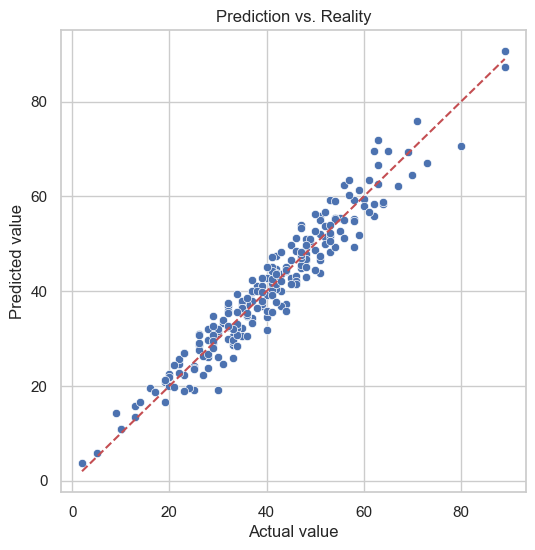

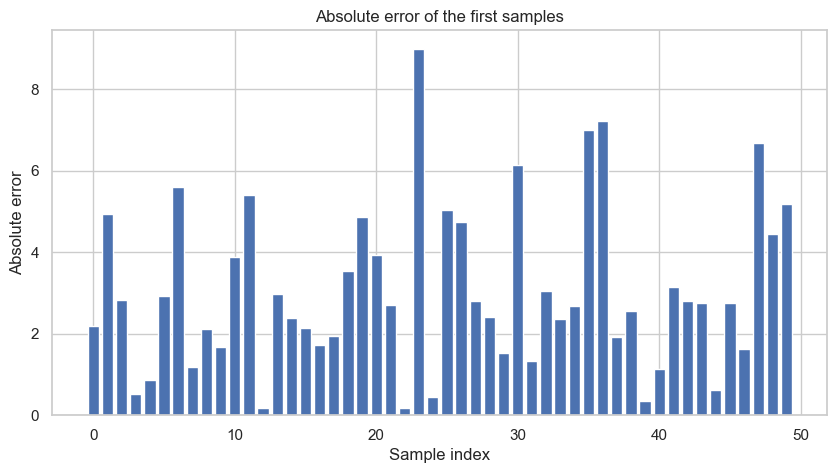

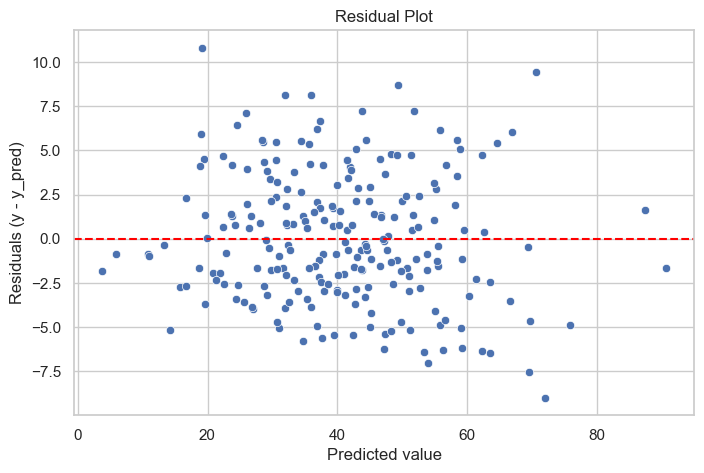

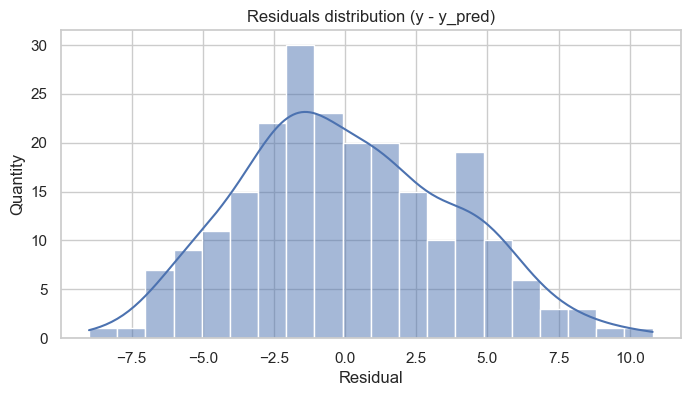

In [30]:
# Calculate residuals and absolute errors
residuals = y_test - y_predict
abs_errors = np.abs(residuals)

# 1. Scatter plot: Actual value and. Prediction
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_predict)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # đường y = x
plt.xlabel("Actual value")
plt.ylabel("Predicted value")
plt.title("Prediction vs. Reality")
plt.grid(True)
plt.show()

# 2. Bar plot: Absolute error of the first 50 samples
plt.figure(figsize=(10, 5))
plt.bar(range(len(abs_errors[:50])), abs_errors[:50])
plt.xlabel("Sample index")
plt.ylabel("Absolute error")
plt.title("Absolute error of the first samples")
plt.show()

# 3. Residual plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_predict, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted value")
plt.ylabel("Residuals (y - y_pred)")
plt.title("Residual Plot")
plt.grid(True)
plt.show()

# 4. Histogram of residuals
plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=20, kde=True)
plt.title("Residuals distribution (y - y_pred)")
plt.xlabel("Residual")
plt.ylabel("Quantity")
plt.grid(True)
plt.show()


### (BONUS 1) Another way to approach data modeling and data evaluation phases : LazyPredict library

LazyPredict function in lazypredict library is fast train function in Machine Learning Supervised and return 30-40 suitable models

In [31]:
applied_step_preprocessing_to_features = Pipeline(steps= [
    ("preprocessor", preprocessor)
])

x_train_for_lazypredict = applied_step_preprocessing_to_features.fit_transform(x_train)
x_test_for_lazypredict = applied_step_preprocessing_to_features.transform(x_test) # Principle: only transform on the test set
    

clf = LazyRegressor(verbose=2, ignore_warnings=True, random_state=42)
clf.use_notebook_tqdm = False # Disable tqdm in Jupyter
models, predictions = clf.fit(x_train_for_lazypredict, x_test_for_lazypredict, y_train, y_test)

  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9002581802040897, 'Adjusted R-Squared': 0.890574508379244, 'RMSE': np.float64(4.510493075233819), 'Time taken': 0.10170578956604004}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9181344778039591, 'Adjusted R-Squared': 0.9101863688528872, 'RMSE': np.float64(4.0863531343149955), 'Time taken': 0.050019264221191406}
{'Model': 'BayesianRidge', 'R-Squared': 0.933694306054189, 'Adjusted R-Squared': 0.9272568600400326, 'RMSE': np.float64(3.677568652986141), 'Time taken': 0.004176139831542969}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.8679097182830314, 'Adjusted R-Squared': 0.8550854190872093, 'RMSE': np.float64(5.1906388120859495), 'Time taken': 0.01804947853088379}
{'Model': 'DummyRegressor', 'R-Squared': -0.01778331648989795, 'Adjusted R-Squared': -0.11659723071221806, 'RMSE': np.float64(14.408309882705467), 'Time taken': 0.004009246826171875}
{'Model': 'ElasticNet', 'R-Squared': 0.8710069869755175, 'Adjusted R-Squared': 0.858483393477995

In [32]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ElasticNetCV,0.92868,0.93499,3.64137,0.03382
RANSACRegressor,0.92795,0.93433,3.65995,0.02987
LassoLarsCV,0.92742,0.93385,3.67337,0.01397
LassoCV,0.92742,0.93384,3.67339,0.04521
LarsCV,0.92728,0.93372,3.67691,0.01488
BayesianRidge,0.92726,0.93369,3.67757,0.00418
Ridge,0.92722,0.93366,3.67852,0.00878
RidgeCV,0.92709,0.93354,3.68177,0.00773
LinearRegression,0.92708,0.93353,3.68213,0.00899


In [33]:
models_sorted = models.sort_values(by=["Adjusted R-Squared","Time Taken"], ascending=[False, True])

view_lazypredict_models = pd.DataFrame(models_sorted)
view_lazypredict_models[["Adjusted R-Squared", "Time Taken"]] = view_lazypredict_models[["Adjusted R-Squared", "Time Taken"]].apply(pd.to_numeric, errors='coerce')

view_lazypredict_models.style.format({
    "Adjusted R-Squared": "{:.5f}",
    "Time Taken": "{:.5f}"
})

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ElasticNetCV,0.92868,0.934993,3.641365,0.03382
RANSACRegressor,0.92795,0.934328,3.659951,0.02987
LassoLarsCV,0.92742,0.933846,3.673367,0.01397
LassoCV,0.92742,0.933845,3.673389,0.04521
LarsCV,0.92728,0.933718,3.676909,0.01488
BayesianRidge,0.92726,0.933694,3.677569,0.00418
Ridge,0.92722,0.933660,3.678516,0.00878
RidgeCV,0.92709,0.933543,3.681766,0.00773
TransformedTargetRegressor,0.92708,0.933530,3.682133,0.00733


Show top 5 as horizontal bar chart

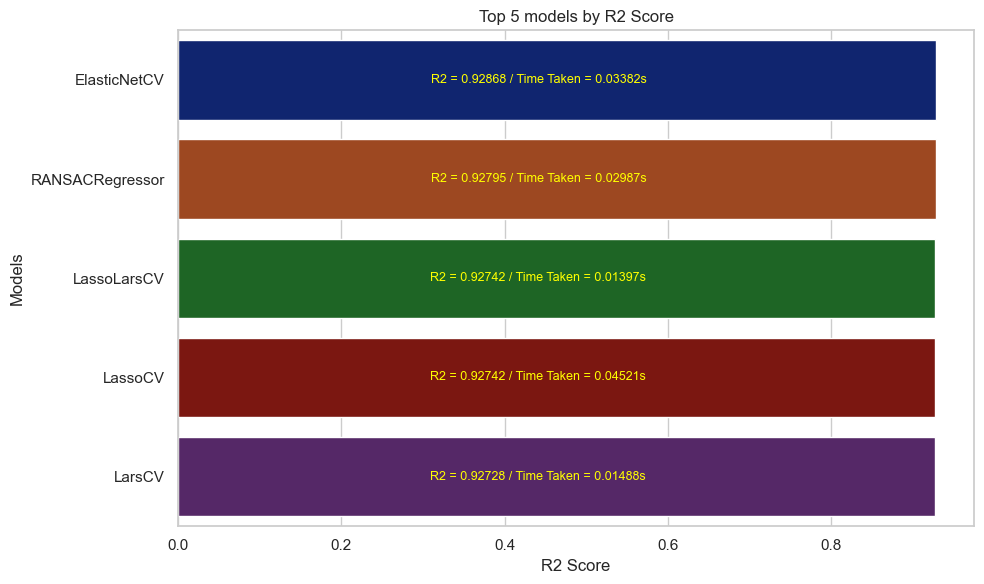

In [34]:
top5_R2 = view_lazypredict_models.head(5)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=top5_R2,
    x="Adjusted R-Squared",
    y="Model",
    palette="dark",
    orient="h"
)

plt.title("Top 5 models by R2 Score")
plt.xlabel("R2 Score")
plt.ylabel("Models")


# Add Time Taken and Accuracy labels to each bar
for i, (r2, time) in enumerate(zip(top5_R2["Adjusted R-Squared"], top5_R2["Time Taken"])):
    ax.text(
        r2/3,                                                     
        i,                                                          
        f"R2 = {r2:.5f} / Time Taken = {time:.5f}s",         
        va="center",                                              
        fontsize=9,
        color="yellow"
    )

plt.tight_layout()
plt.show()

<div align="center">

### - END -

</div>
